In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [45]:
data = pd.read_csv('sorghum_2022_whole.csv')

In [46]:
data =data.loc[data['355'].notnull(), :]

In [47]:
data = data.loc[data['355']>0 , :]

In [48]:
data = data.loc[data['1000'] > 0.33 , :]

In [49]:
data['CHL'] = data[['CHLp1', 'CHLp2', 'CHLp3']].mean(axis=1)

In [50]:
data.head()

,Date Recd,Date Rept,Genotype,Rep,Sample ID,P,K,S,Ca,Mg,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,CHL
0,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.071300,0.0707,0.0698,0.069483,0.07050,0.0701,0.0685,0.0683,0.0684,413.333333
1,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.074300,0.0740,0.0743,0.074400,0.07416,0.0736,0.0724,0.0726,0.0741,413.333333
2,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.061000,0.0605,0.0597,0.059500,0.05930,0.0587,0.0582,0.0582,0.0580,413.333333
3,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.075948,0.0754,0.0729,0.072100,0.07200,0.0717,0.0726,0.0726,0.0722,498.933333
4,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.082870,0.0823,0.0813,0.080900,0.07990,0.0796,0.0812,0.0816,0.0816,498.933333


In [51]:
import copy
data_test = copy.deepcopy(data)

data_test.head()

my_group = data_test.groupby(['Genotype', 'Rep']).mean()

my_group.head()

P     K      S     Ca     Mg    Zn     Fe     Mn    Cu  \
Genotype Rep                                                               
1        1    0.212  1.96  0.211  1.676  0.776  79.0  196.0  139.0  15.6   
         2    0.273  2.17  0.204  1.237  0.614  66.0  150.0   94.0  14.7   
2        1    0.510  1.85  0.195  1.402  0.638  84.0  128.0  167.0  12.3   
         2    0.649  1.54  0.241  2.080  0.926  92.0  151.0  217.0  15.8   
4        1    0.292  1.52  0.137  0.700  0.396  35.0  154.0   26.0  17.0   

                 B  ...      2492      2493      2494      2495      2496  \
Genotype Rep        ...                                                     
1        1    21.2  ...  0.074093  0.073731  0.073122  0.072774  0.072529   
         2    23.8  ...  0.072218  0.071893  0.071624  0.071518  0.071791   
2        1    49.1  ...  0.045160  0.044659  0.043533  0.043155  0.042783   
         2    51.1  ...  0.044433  0.044253  0.043939  0.043714  0.043111   
4        1    55.5  ...  0.064289  0.064083  0.063794  0.063567  0.063478   

                  2497      2498      2499      2500         CHL  
Genotype Rep                                                      
1        1    0.072144  0.071700  0.071611  0.071944  431.777778  
         2    0.071510  0.070941  0.070632  0.069888  315.222222  
2        1    0.042633  0.043460  0.043559  0.043034  720.083333  
         2    0.042863  0.043029  0.043048  0.042944  409.122222  
4        1    0.063435  0.063330  0.063222  0.063345  541.088889  

[5 rows x 2174 columns]

In [52]:
my_group = my_group.reset_index()

In [53]:
my_group.columns[0:15]

Index(['Genotype', 'Rep', 'P', 'K', 'S', 'Ca', 'Mg', 'Zn', 'Fe', 'Mn', 'Cu',
       'B', 'Mo', 'Leaf_num', 'CHLp1'],
      dtype='object')

In [54]:
trait = 'B'

In [55]:
y = my_group.loc[: , trait]

In [56]:
X_total = my_group.iloc[:, 24:2175]

In [57]:
X_total.drop(columns = X_total.columns[0:100], inplace = True) 

In [58]:
X_total

,450,451,452,453,454,455,456,457,458,459,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.063522,0.063981,0.064120,0.064415,0.064867,0.064756,0.064767,0.065000,0.065256,0.064900,...,0.074209,0.074093,0.073731,0.073122,0.072774,0.072529,0.072144,0.071700,0.071611,0.071944
1,0.083090,0.083374,0.082956,0.082938,0.083556,0.084085,0.084164,0.084198,0.084582,0.084875,...,0.072651,0.072218,0.071893,0.071624,0.071518,0.071791,0.071510,0.070941,0.070632,0.069888
2,0.058764,0.058700,0.058267,0.058035,0.058200,0.058660,0.059227,0.059433,0.059083,0.059113,...,0.045457,0.045160,0.044659,0.043533,0.043155,0.042783,0.042633,0.043460,0.043559,0.043034
3,0.048535,0.048478,0.048178,0.048233,0.048740,0.048918,0.049146,0.049285,0.049167,0.049423,...,0.044278,0.044433,0.044253,0.043939,0.043714,0.043111,0.042863,0.043029,0.043048,0.042944
4,0.068367,0.068070,0.068589,0.069044,0.068944,0.068633,0.068389,0.068796,0.069764,0.069411,...,0.064662,0.064289,0.064083,0.063794,0.063567,0.063478,0.063435,0.063330,0.063222,0.063345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.099893,0.100610,0.101008,0.101394,0.101838,0.102013,0.102350,0.102878,0.103481,0.103581,...,0.087074,0.086616,0.086369,0.085814,0.085228,0.084951,0.084582,0.083503,0.083202,0.083970
116,0.075186,0.075989,0.076267,0.076411,0.076719,0.077338,0.077648,0.077595,0.077472,0.078088,...,0.064874,0.064473,0.064240,0.063900,0.063589,0.063533,0.063400,0.063154,0.063102,0.063589
117,0.084809,0.085060,0.085800,0.086108,0.086063,0.086951,0.087080,0.086999,0.087456,0.087802,...,0.074328,0.074142,0.073891,0.074272,0.074044,0.073078,0.072771,0.072822,0.072533,0.072333
118,0.052522,0.052322,0.052622,0.053099,0.053477,0.053764,0.054113,0.054189,0.053901,0.054333,...,0.070356,0.069540,0.069076,0.068956,0.068625,0.068402,0.068133,0.067705,0.067379,0.067107


In [59]:
min(X_total['1000'])

0.4131543222222222

([<matplotlib.axis.XTick at 0x7f58ef9ae2e8>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

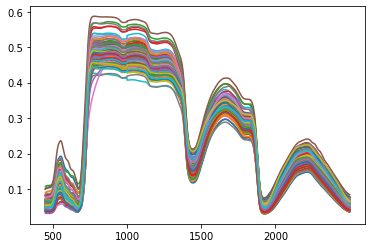

In [60]:
plt.plot(X_total.T)
plt.xticks(['500', '1000', '1500' , '2000'])

In [61]:
column_filter = np.arange(0,2050,5)  ## creating an index for column filtering
X= X_total.iloc[:, column_filter] # selecting the filtered columns 

In [62]:
X[X.isnull().any(axis=1)]

,450,455,460,465,470,475,480,485,490,495,...,2450,2455,2460,2465,2470,2475,2480,2485,2490,2495


In [63]:
#define the cv
cv = RepeatedKFold(n_splits=10)
rmse = []

#Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 40):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X, y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))

n_comp = rmse.index(min(rmse)) +1 

In [64]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.4) 

In [65]:
rsqu = [] 
for i in np.arange(1, 50):
    pls = PLSRegression(n_components= i)
    pls.fit(X, y)
    y_pred = pls.predict(X_test)
    r , p = spearmanr(y_test , y_pred)
    rsqu.append(r**2)
    n_comb = rsqu.index(max(rsqu)) +1

NameError: name 'spearmanr' is not defined

In [ ]:
### calculate RMSE
pls = PLSRegression(n_components=n_comp)
pls.fit(X_train, y_train)

In [ ]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

In [ ]:
y_pred = pls.predict(X_test)

In [ ]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted CHL values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)

In [ ]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r2, p)